In [121]:
# import des modules nécessaires
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import matplotlib.patches as mpatches
from distinctipy import distinctipy
from matplotlib.font_manager import FontProperties
from matplotlib import rc
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import clear_output, display
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.formula.api as statsapi
import statsmodels as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import xlrd as xlrd
from matplotlib import font_manager # for mac users
import platform
import os
from sklearn.decomposition import PCA

# Modifier les paramètres d'affichage de la sortie des commandes dans Jupyter
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

# Pour lister les polices présentes
#fpaths = matplotlib.font_manager.findSystemFonts()
#for i in fpaths:
#    f = matplotlib.font_manager.get_font(i)
#    print(f.family_name)
# import de la police Garamond

system = platform.system()
print(system)
if system == 'Darwin':  # macOS
  font_path = '/Library/Fonts/GaramondPremrPro.otf'
elif system == 'Windows':
  font_path = 'C:/Windows/Fonts/Garamond.TTF'
else:  #  unix
  font_path = 'GARA.TTF'
print(font_path)

garamond_font = FontProperties(fname="/Library/Fonts/GaramondPremrPro.otf",size=14) # for MAC
garamond_font = FontProperties(fname="/Library/Fonts/Garamond.otf",size=14) # for WINDOWS

#    timesnewroman_font = FontProperties(fname="C:/Windows/Fonts/TIMES.TTF",size=14)

font_manager.findSystemFonts(fontpaths=font_path, fontext="ttf")
font_manager.findfont("Garamond Premier Pro") 

# Définissez la police par défaut pour toute la figure
matplotlib.rcParams['font.family'] = 'Garamond'

Windows
C:/Windows/Fonts/Garamond.TTF


In [259]:
# Chargement des données CANCER DU SEIN
df_bc_data = pd.read_table("input/mlsupervise/wdbc.data",sep=",")
#df_bc_names = pd.read_table("input/mlsupervise/wdbc.names",sep=",")

# Ajout titre colonnes
df_bc_data.columns=["ID",
                    "diagnosis",
                    "radius_mean",
                    "texture_mean",
                    "flipper_length_mm",
                    "smoothness_mean",
                    "compactness_mean",
                    "concavity_mean",
                    "concave_points_mean",
                    "symmetry",
                    "fractal_dimension_mean",
                    "12","13","14","15","16","17","18","19","20",
                    "21","22","23","24","25","26","27","28","29","30","31","32"]
print(df_bc_data.iloc[0:5,0:10])
# Verif données
#print("Cols: ",df_bc_data.columns)
#print(df_bc_data.isna().count())
print(type(df_bc_data))
print(df_bc_data.shape)

# ==> Pas de valeurs manquantes

         ID diagnosis  radius_mean  texture_mean  flipper_length_mm  smoothness_mean  \
0    842517         M        20.57         17.77             132.90           1326.0   
1  84300903         M        19.69         21.25             130.00           1203.0   
2  84348301         M        11.42         20.38              77.58            386.1   
3  84358402         M        20.29         14.34             135.10           1297.0   
4    843786         M        12.45         15.70              82.57            477.1   

   compactness_mean  concavity_mean  concave_points_mean  symmetry  
0           0.08474         0.07864               0.0869   0.07017  
1           0.10960         0.15990               0.1974   0.12790  
2           0.14250         0.28390               0.2414   0.10520  
3           0.10030         0.13280               0.1980   0.10430  
4           0.12780         0.17000               0.1578   0.08089  
<class 'pandas.core.frame.DataFrame'>
(568, 32)


Projet 2. Le cancer du sein

In [251]:
# Projet 2. Question 1

# import des librairies
from sklearn.model_selection import train_test_split
#print(df_bc_data)
X=df_bc_data.drop(columns={"M"})
print("X: ",X.iloc[:,0:9].head(5))
y=df_bc_data.iloc[:,2:3]
print("y :", y.iloc[:,0:9].head(5))

# Split du jeu de données
X_train_temp, X_test_temp, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, shuffle=False, stratify=None)

# Reset index
X_train_temp.reset_index(inplace=True)
X_test_temp.reset_index(inplace=True)
y_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

print("X_train_temp ", X_train_temp.shape)
print("X_test_temp ", X_test_temp.shape)
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

X:     index    842302  17.99  10.38   122.8    1001   0.1184   0.2776  0.3001
0      0    842517  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869
1      1  84300903  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974
2      2  84348301  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414
3      3  84358402  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980
4      4    843786  12.45  15.70   82.57   477.1  0.12780  0.17000  0.1578
y :    M
0  M
1  M
2  M
3  M
4  M
X_train_temp  (454, 33)
X_test_temp  (114, 33)
y_train  (454, 2)
y_test  (114, 2)


In [250]:
# Remplacement des valeurs de y_train par 1 ou 0
y_train.replace({"M": 1, "B": 0},inplace=True)

# Remplacement des valeurs de y_test par 1 ou 0
y_test.replace({"M": 1, "B": 0},inplace=True)

# Extraction des 2 features radius_mean et concavepoints_mean pour train
radius_mean_train = X_train_temp.iloc[:,2]
concave_points_mean_train = X_train_temp.iloc[:,7]
X_train = pd.concat([radius_mean_train,concave_points_mean_train],axis=1, ignore_index=True) # Reforme X_train avec les 2 colonnes
print(X_train.head(5))

# Extraction des 2 features radius_mean et concavepoints_mean pour test
radius_mean_test = X_test_temp.iloc[:,2]
concave_points_mean_test = X_test_temp.iloc[:,7]
X_test = pd.concat([radius_mean_test,concave_points_mean_test],axis=1, ignore_index=True) # Reforme X_test avec les 2 colonnes
print(X_test.head(5))

print("y_train ", y_train.reset_index(inplace=True))
print("y_test ", y_test.reset_index(inplace=True))

print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

       0        1
0  20.57  0.07864
1  19.69  0.15990
2  11.42  0.28390
3  20.29  0.13280
4  12.45  0.17000
          0        1
454  13.380  0.07426
455  11.630  0.08574
456  13.210  0.05205
457  13.000  0.05073
458   9.755  0.04626


ValueError: cannot insert level_0, already exists

In [242]:
import sklearn
from sklearn import tree
#from sklearn.tree import tree
from sklearn.tree import DecisionTreeClassifier

# Entrainement d'un modèle de Classifier et de X_train, y_train

dt = DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=6)
dt = dt.fit(X_train,y_train)

# Prédiction à l'aide du modèle et de X_test et y_test

y_pred=dt.predict(X_test)
print("Prédiction: ",a[0:10]) # affichage de la prediction
print("y_test: ", y_test.iloc[0:10]) # affichage de la réalité y_test pour comparaison avec la prediction

Prédiction:  [0 0 0 0 0 1 1 0 0 1]
y_test:          842302
454    9112085
455    9112366
456    9112367
457    9112594
458    9112712
459  911296201
460  911296202
461    9113156
462  911320501
463  911320502


['radius_mean', 'concave_points_mean']
['B', 'M']


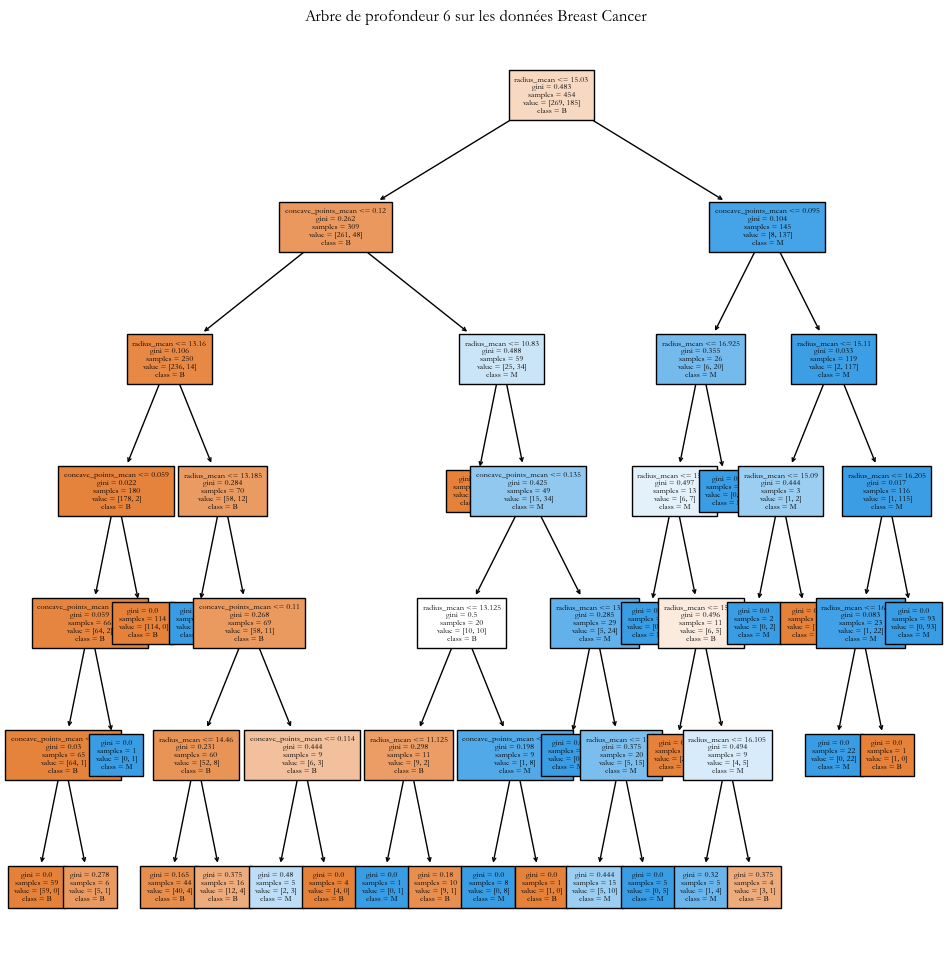

In [230]:
# Verification des données
feature_names=["radius_mean","concave_points_mean"]
class_names=["B","M"]
print(feature_names)
print(class_names)

# Affichage de l'Arbre
fig = plt.figure(figsize=(12,12))
tree.plot_tree(dt,filled=True, feature_names=feature_names,class_names=class_names,fontsize=6)
plt.title("Arbre de profondeur 6 sur les données Breast Cancer")
plt.show()

In [232]:
from sklearn.metrics import accuracy_score
print(y_test)
accuracy_score(y_test, y_pred)

     M
454  B
455  B
456  B
457  B
458  B
..  ..
563  M
564  M
565  M
566  M
567  B

[114 rows x 1 columns]


TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['B' 'M'] and y_pred=[0 1]. Make sure that the predictions provided by the classifier coincides with the true labels.

In [88]:
# Définition des tableaux de données X et Y
#X = df_pingouin[["culmen_length_mm","culmen_depth_mm"]]
#Y = df_pingouin["species"] # Target names
#print(len(X))
#print(len(Y))
# Rename pour être plus parlant
#features_values=X.loc[1:,:].values
#features_names=X.columns.values
#target_names = Y.loc[1:].values
#print(len(features_values))
#print(target_names)
# Entrainement d'un arbre de profondeur 1
#clf = DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=1)
#clf = clf.fit(features_values,target_names)

# Affichage de l'Arbre
#fig = plt.figure()
#plot_tree(clf,filled=True, feature_names=features_names,class_names=["Adelie","Chinstrap","Gentoo"])
#plt.title("Arbre de profondeur 1 sur les données Pingouin")
#plt.show()



(array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]]), range(0, 5))
